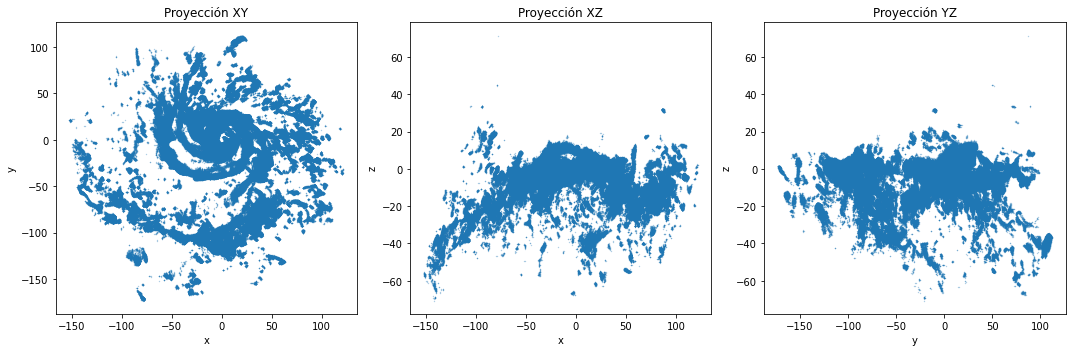

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo
df = pd.read_csv("halo_117251_datos_hull_withindex.csv")

# Crear la figura y los subplots
plt.figure(figsize=(15, 5))

# XY
plt.subplot(1, 3, 1)
plt.scatter(df['x'], df['y'], s=0.1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Proyección XY')

# XZ
plt.subplot(1, 3, 2)
plt.scatter(df['x'], df['z'], s=0.1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Proyección XZ')

# YZ
plt.subplot(1, 3, 3)
plt.scatter(df['y'], df['z'], s=0.1, alpha=0.5)
plt.xlabel('y')
plt.ylabel('z')
plt.title('Proyección YZ')

plt.tight_layout()
plt.show()


[2025-06-29T15:03:02.048798 UTC] Datos cargados: 646373 filas, 13 columnas


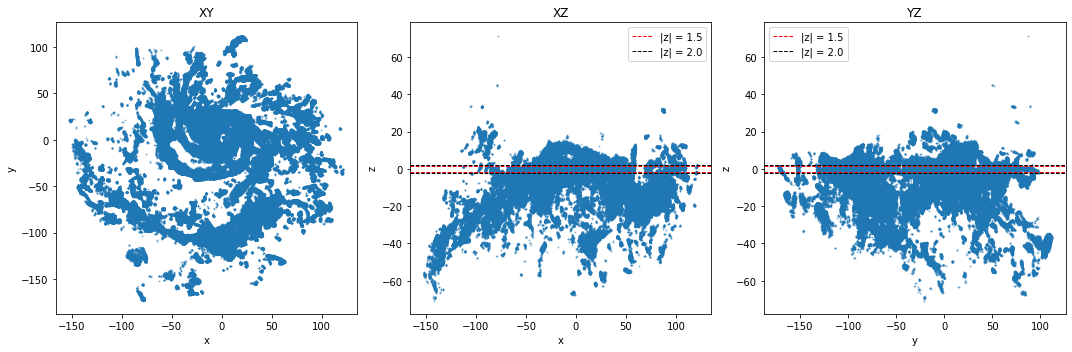

In [2]:
# %%
# Notebook interactivo para procesar un halo de TNG50 paso a paso
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

# %%
def log(msg: str) -> None:
    from datetime import datetime
    print(f"[{datetime.utcnow().isoformat()} UTC] {msg}")

# %%
# Cargar datos desde CSV
file_path = "halo_117251_datos_hull_withindex.csv"
cols_required = [
    "x", "y", "z", "vx", "vy", "vz",
    "lxvel", "lyvel", "lzvel", "Potential", "U",
    "rho", "index_id",
]
df = pd.read_csv(file_path, usecols=cols_required)
log(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Proyección XY (sin cortes en Z)
axs[0].scatter(df['x'], df['y'], s=1, alpha=0.4)
axs[0].set_xlabel("x"); axs[0].set_ylabel("y"); axs[0].set_title("XY")

# Proyección XZ con líneas horizontales
axs[1].scatter(df['x'], df['z'], s=1, alpha=0.4)
axs[1].axhline(y=1.5, color='red', linestyle='--', linewidth=1, label='|z| = 1.5')
axs[1].axhline(y=-1.5, color='red', linestyle='--', linewidth=1)
axs[1].axhline(y=2.0, color='black', linestyle='--', linewidth=1, label='|z| = 2.0')
axs[1].axhline(y=-2.0, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel("x"); axs[1].set_ylabel("z"); axs[1].set_title("XZ")
axs[1].legend()

# Proyección YZ con líneas horizontales
axs[2].scatter(df['y'], df['z'], s=1, alpha=0.4)
axs[2].axhline(y=1.5, color='red', linestyle='--', linewidth=1, label='|z| = 1.5')
axs[2].axhline(y=-1.5, color='red', linestyle='--', linewidth=1)
axs[2].axhline(y=2.0, color='black', linestyle='--', linewidth=1, label='|z| = 2.0')
axs[2].axhline(y=-2.0, color='black', linestyle='--', linewidth=1)
axs[2].set_xlabel("y"); axs[2].set_ylabel("z"); axs[2].set_title("YZ")
axs[2].legend()

plt.tight_layout()
plt.show()



[2025-06-29T15:11:55.011493 UTC] Filas tras filtrado espacial: 382627 / 646373


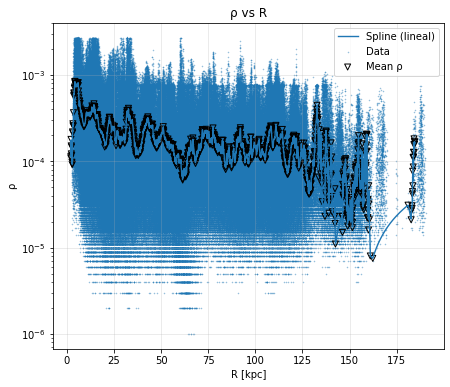

In [9]:

# Cálculo Rs y filtrado espacial del disco

df["Rs"] = np.sqrt(df.x**2 + df.y**2)
df["Zs"] = df.z
df_sorted = df.sort_values("Rs")
df_disk = df_sorted[(df_sorted.Zs.abs() <= 7) & (df_sorted.Rs > 0.7)]
log(f"Filas tras filtrado espacial: {len(df_disk)} / {len(df_sorted)}")

# %%
# Perfil radial promedio

deltaR = 0.1
Rmax = np.floor(0.97 * df_disk.Rs.max() / deltaR) * deltaR
Rs_mean, rho_mean = [], []
step = 0.0
while step + deltaR <= Rmax:
    mask = (df_disk.Rs > step) & (df_disk.Rs <= step + deltaR)
    if mask.any():
        Rs_mean.append(round((df_disk.Rs[mask].min() + df_disk.Rs[mask].max()) * 0.5, 2))
        rho_mean.append(df_disk.rho[mask].mean())
    step += deltaR
Rs_mean, rho_mean = np.array(Rs_mean), np.array(rho_mean)
ylog = np.log10(rho_mean)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(df_sorted.Rs, df_sorted.rho, s=0.3, alpha=0.45, label="Data")
ax.scatter(Rs_mean, rho_mean, facecolors="none", edgecolors="k", marker="v", label="Mean ρ")
xprof = np.linspace(Rs_mean.min(), Rs_mean.max(), 2000)
spline = interpolate.interp1d(Rs_mean, rho_mean, kind="linear", fill_value="extrapolate")
ax.plot(xprof, spline(xprof), lw=1.4, label="Spline (lineal)")
ax.set(title="ρ vs R", xlabel="R [kpc]", ylabel="ρ", yscale="log")
ax.grid(alpha=0.3); ax.legend()
plt.show()


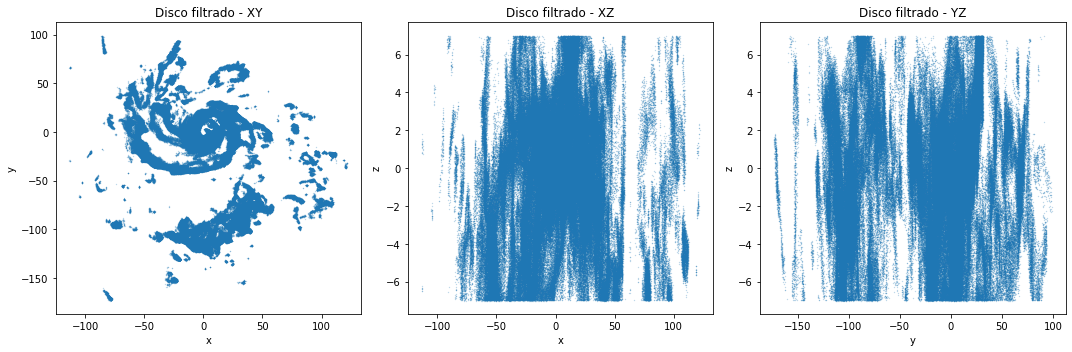

In [10]:
# Visualización del disco filtrado en XY, XZ y YZ

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df_disk['x'], df_disk['y'], s=0.1, alpha=0.4)
axs[0].set_xlabel("x"); axs[0].set_ylabel("y"); axs[0].set_title("Disco filtrado - XY")

axs[1].scatter(df_disk['x'], df_disk['z'], s=0.1, alpha=0.4)
axs[1].set_xlabel("x"); axs[1].set_ylabel("z"); axs[1].set_title("Disco filtrado - XZ")

axs[2].scatter(df_disk['y'], df_disk['z'], s=0.1, alpha=0.4)
axs[2].set_xlabel("y"); axs[2].set_ylabel("z"); axs[2].set_title("Disco filtrado - YZ")

plt.tight_layout()
plt.show()


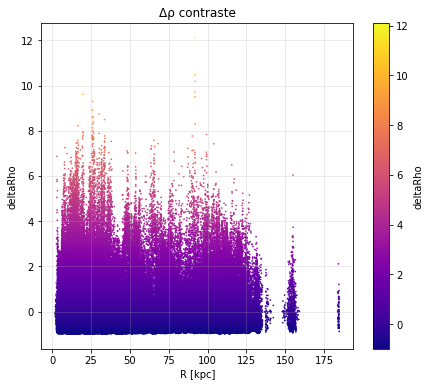

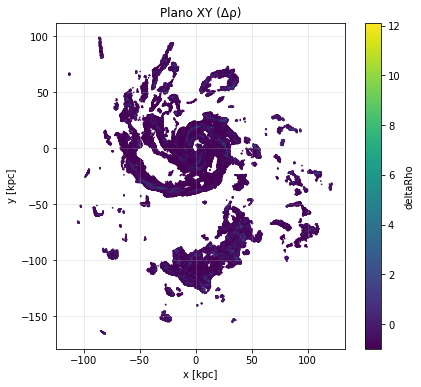

In [8]:

# %%
# Calcular deltaRho y visualizar contraste

df_lim = df_disk[(df_disk.Rs > Rs_mean.min()) & (df_disk.Rs < Rs_mean.max())].copy()
df_lim["rho_sph_log"] = np.log10(df_lim.rho)
df_lim["deltaRho"] = df_lim.rho / spline(df_lim.Rs) - 1.0

fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(df_lim.Rs, df_lim.deltaRho, s=0.45, c=df_lim.deltaRho, cmap="plasma")
ax.set(title="Δρ contraste", xlabel="R [kpc]", ylabel="deltaRho")
fig.colorbar(sc, ax=ax, label="deltaRho")
ax.grid(alpha=0.3)
plt.show()

# %%
# Visualizar plano XY coloreado por deltaRho

fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(df_lim.x, df_lim.y, s=0.45, c=df_lim.deltaRho, cmap="viridis")
ax.set(title="Plano XY (Δρ)", xlabel="x [kpc]", ylabel="y [kpc]")
ax.set_aspect("equal", "box")
fig.colorbar(sc, ax=ax, label="deltaRho")
ax.grid(alpha=0.3)
plt.show()
